In [4]:
#!/usr/bin/env python
# coding: utf-8

## Lendo os dados e Configurações do Matplotlib<br>


In[11]:

mportações e configurações

In [5]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [6]:
from sys import version

In [7]:
from IPython.display import display, HTML

onfigurações do Matplotlib

In [8]:
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "font.sans-serif": "Times",
    "font.size" : 10,
})
#Versões das bibliotecas
print("python version: ", version)
print("Numpy version: ", np.__version__)
print("Pandas version: ", pd.__version__)

python version:  3.12.3 (main, Jun 18 2025, 17:59:45) [GCC 13.3.0]
Numpy version:  2.3.1
Pandas version:  2.3.0


In [9]:
from envcity_plot_lib import *

In [10]:
from alphasense_b_sensors.alphasense_sensors import *

In[12]:

!wget https://media.githubusercontent.com/media/MateusMaruzka/aqm-dataset/main/envcity_aqm_df.csv -O aqm.csv

In[13]:

In [11]:
#!wget https://raw.githubusercontent.com/MateusMaruzka/aqm_envcity_sw/main/alphasense_sensors.py -O alphasense_sensors.py
#!wget https://raw.githubusercontent.com/MateusMaruzka/aqm_envcity_sw/main/dados_correcao_temp.py -O dados_correcao_temp.py
#!wget https://raw.githubusercontent.com/MateusMaruzka/aqm_envcity_sw/main/dados_alphasense.py -O dados_alphasense.py

## Organizando o dataset

In[14]:

Leitura do dataset

In [12]:
aqm = pd.read_csv('envcity_aqm_df.csv')
print(aqm.shape)
print(aqm.describe())
#%%

(194485, 181)
            e1_anem  e1_anem_volt         e1_co       e1_co_2       e1_co_3  \
count  43464.000000  25641.000000  43464.000000  43464.000000  43464.000000   
mean       8.784224      0.501088   -257.343391    232.316820    186.055181   
std        2.550723      0.018040   1619.857223    900.151430    886.591724   
min        0.000000      0.000000 -25741.396484 -15297.602539 -15306.832031   
25%        8.342664      0.498188   -285.960434    110.959763     46.315489   
50%        8.472690      0.503438    232.782364    187.673752    118.113029   
75%       10.501109      0.507937    332.472198    293.837364    227.100555   
max       36.000000      0.619500  14709.538086  13169.983398  13040.117188   

            e1_co_4      e1_co_ae      e1_co_we  e1_location        e1_no2  \
count  43464.000000  25641.000000  25641.000000          0.0  43464.000000   
mean    -393.044602      0.308851      0.462073          NaN     40.933911   
std      891.801038      0.069943      0

impeza de colunas não utilizadas

In [13]:
from itertools import product

In [14]:
for label, p, s in product(['anem'], ['e1_', 'e2_', 'e2sp_'], ['_volt', '']):
    print(p + label+s)
    try:
        aqm.drop(labels = p + label + s, axis = 1,inplace=True)
    except:
        print('err')
# aqm.set_index('time', inplace=True)

e1_anem_volt
e1_anem
e2_anem_volt
e2_anem
e2sp_anem_volt
e2sp_anem


In[34]:

In [15]:
aqm_filtered = aqm.copy()

Remoção de linhas com valores inválidos

In [16]:
for index, row in aqm.iterrows():
    if (row == -3).sum() > 0:
        aqm_filtered.drop(index, inplace=True)
# In[36]:

aqm_filtered.reset_index(drop=True)

In [17]:
aqm_filtered.set_index('time', inplace=True)
aqm = aqm_filtered

%

In [18]:
print(aqm.shape)
#%%
# ## Filtro por limites físicos dos sensores
labels =  ['co', 'so2', 'ox', 'no2']
prefix = ['e1_', 'e2_', 'e2sp_']
suffix = ['_ae', '_we']

(193809, 174)


In [19]:
for label, p, s in product(labels, prefix, suffix):
  data = aqm[p+label+s]
  idx = (data > 6.14) | (data < 0.05)
  data.loc[idx] = np.nan

In [20]:
for p in prefix:
  data = aqm[p + 'temp']
  idx = (data > 50) | (data <= 1)
  data.loc[idx] = np.nan
  
#%%
# ## Verificando colunas faltantes
print(aqm.shape)
# In[37]:

(193809, 174)


aqm.describe()

## Métricas de Avaliação<br>
<br>
* Métricas de avaliação [https://amt.copernicus.org/articles/11/291/2018/amt-11-291-2018.pdf]<br>
1. $R^2$<br>
<br>
2. **Pearson r**<br>
<br>
3. $\mathrm{RMSE} = \sqrt{\frac{\sum_{i=1}^{N}(y_{ref} - \hat{y})^{2})}{N}}$<br>
<br>
4. $\mathrm{CvMAE} = \frac{\overbrace{MAE}^{\textrm{Mean absolute error}}}{\mu_{ref}} = \frac{1}{\mu_{ref}} \frac{\sum_{i=1}^{N}{|y_{ref} - \hat{y}}|}{N}$<br>


In[38]:

In [21]:
def pearson_r(y, yref):
    my = np.mean(y)
    myref = np.mean(yref)
    _y = y - my
    _yref = yref - myref
    num = np.sum(np.dot(_y, _yref))
    den = np.sum(_y**2) * np.sum(_yref**2)
    den = np.sqrt(den)
    return num/den

In [22]:
def mse(y, yref):
    return np.mean(np.square(np.subtract(yref, y)))

In [23]:
def rmse(y, yref):
    return np.sqrt(mse(y, yref))

In [24]:
def mae(y, yref):
    return np.mean(np.abs(np.subtract(yref, y)))

In [25]:
def cvmae(y, yref):
    yref_mean = np.mean(yref)
    return mae(y, yref) / yref_mean

In[39]:

In [26]:
def exploratory_analysis(dict_data_e1, dict_data_e2, labels, latex_labels, start, end):
    table_exploratory_analysis = {}
    for idx, l in enumerate(labels):
        e1 = dict_data_e1[l]
        e2 = dict_data_e2[l]
        concatenated = pd.concat([e1, e2], axis=1, keys=['Station 1', 'Station 2'])
        table_exploratory_analysis[l] = describe(concatenated, ['median'], ['25%', '50%', '75%'])
    return table_exploratory_analysis

### Funções Gráficos<br>
<br>
**plot_data_by_time_and_regr_plot** gera dois gráficos, um do lado do outro. O primeiro é os dados em função do tempo e o segundo é um gráfico de dispersão entre os dois sensores

In[40]:

### Análise

#### Resultados complementas:<br>
1. Comunicação degrada a partir de 30 graus<br>
2. Pode estar relacionada ao CI SX1276<br>
<br>
Ações:<br>
Dropar toda as linhas com erro

In[41]:

atex_labels it is only for printing<br>
latex_labels = ['CO', 'NO_2', 'O_X', 'SO_2', 'PM1.0', 'PM2.5', 'PM10']

for label in labels:<br>
  for p in preffix:<br>
    plt.figure()

In [27]:
    
#     data_filtered = aqm[p+label]
        
#     data_temp = aqm[p+'temp']
    
#     data_filtered = data_filtered.dropna()
#     data_temp = data_temp.dropna()
    
#     teste = pd.concat([data_filtered, data_temp], axis =1)
    
#     plt.gca().scatter(y = teste[p+label], x=teste[p+'temp'], marker = '.')
#     plt.gca().set_xlabel('Temperatura')
#     plt.gca().set_ylabel('Tensão')
#     plt.title(label)

    plt.show()<br>
    print(aqm[p+label].min(), aqm[p+label].max())<br>
%<br>
## Checando ausência de umidade relativa

In [28]:
pin_ur = aqm['pin_umid'].isna().sum()
print(pin_ur)

41828


%<br>
['2023-03-18 10:00:00':'2023-03-22 10:00:00'].

## Plot dos dados brutos: sensor vs. umidade relativa

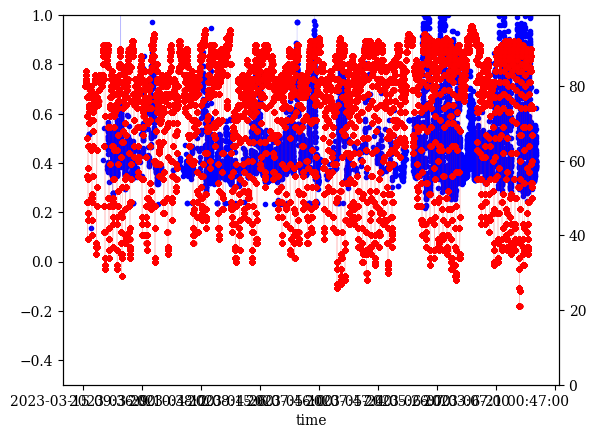

In [29]:
plt.figure()
aqm['e2sp_co_we'].plot(marker = '.', linewidth = 0.1, color = 'b')
plt.gca().set_ylim([-0.5, 1])
ax = plt.gca().twinx()
aqm['pin_umid'].plot(marker = '.', linewidth = 0.1, ax = ax, color = 'r')
ax.set_ylim([0, 99])
# plt.gcf().autofmt_xdate()
plt.show()

%<br>
mportação de modelos e métricas do scikit-learn

In [30]:
from sklearn.linear_model import LinearRegression

In [31]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, KernelCenterer,Normalizer

In [32]:
from sklearn.pipeline import make_pipeline

In [33]:
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor

In [34]:
from sklearn.neural_network import MLPRegressor

In [35]:
from sklearn.metrics import r2_score

In [36]:
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV,\
                                    validation_curve, cross_val_score, \
                                    cross_validate, \
                                    RepeatedKFold, cross_val_predict, StratifiedKFold
from sys import version

%

In [37]:
 ## Preparo do dataset para regressão
labels =  ['co_we', 'co_ae']
preffix = ['e2sp_']
label_ref= 'iag_co'

In [38]:
df = aqm

In [39]:
df = aqm[[preffix[0] + labels[0], preffix[0] + labels[1], 'pin_umid', label_ref]]
df

,e2sp_co_we,e2sp_co_ae,pin_umid,iag_co
time,,,,
2023-02-15 13:41:00,NaN,NaN,NaN,NaN
2023-02-15 13:42:00,NaN,NaN,NaN,NaN
2023-02-15 13:43:00,NaN,NaN,NaN,NaN
2023-02-15 13:44:00,NaN,NaN,NaN,NaN
2023-02-15 13:45:00,NaN,NaN,NaN,NaN
...,...,...,...,...
2023-06-30 15:01:00,NaN,NaN,NaN,NaN
2023-06-30 15:02:00,NaN,NaN,NaN,NaN
2023-06-30 15:03:00,NaN,NaN,NaN,NaN


In [40]:
df.index = pd.to_datetime(df.index)
df = df.resample('15min').mean()
# df = df.interpolate(method = 'time', limit=5)
df = df.dropna()
#
print(df.shape)
df
#%%

(3606, 4)


,e2sp_co_we,e2sp_co_ae,pin_umid,iag_co
time,,,,
2023-03-16 21:00:00,0.517687,0.527812,75.0,1.405933
2023-03-16 21:15:00,0.517687,0.527812,75.0,1.410133
2023-03-19 15:15:00,3.000000,4.000000,83.0,1.340000
2023-03-20 05:00:00,0.411938,0.287250,90.0,1.412533
2023-03-20 06:45:00,0.540187,0.288375,91.0,1.485333
...,...,...,...,...
2023-06-23 10:45:00,0.574346,0.256217,55.0,2.296733
2023-06-23 11:00:00,0.505305,0.253775,47.0,2.178067
2023-06-23 11:15:00,0.449196,0.231416,47.0,2.085533


## Cálculo da concentração em ppm com coeficientes da Alphasense

In [41]:
co = Alphasense_Sensors("CO-B4", "162741354")
no2 = Alphasense_Sensors("NO2-B43F", "202742056")
so2 = Alphasense_Sensors("SO2-B4", "164240348")
ox = Alphasense_Sensors("OX-B431", "204240461")
df

,e2sp_co_we,e2sp_co_ae,pin_umid,iag_co
time,,,,
2023-03-16 21:00:00,0.517687,0.527812,75.0,1.405933
2023-03-16 21:15:00,0.517687,0.527812,75.0,1.410133
2023-03-19 15:15:00,3.000000,4.000000,83.0,1.340000
2023-03-20 05:00:00,0.411938,0.287250,90.0,1.412533
2023-03-20 06:45:00,0.540187,0.288375,91.0,1.485333
...,...,...,...,...
2023-06-23 10:45:00,0.574346,0.256217,55.0,2.296733
2023-06-23 11:00:00,0.505305,0.253775,47.0,2.178067
2023-06-23 11:15:00,0.449196,0.231416,47.0,2.085533


to mV

In [42]:
we = df[preffix[0] + labels[0]]*1000
ae = df[preffix[0] + labels[1]]*1000
# temp = df[preffix[0] + 'temp']
# ppb, _ , _ , _ = co.all_algorithms(we, ae, temp.to_numpy())
we

time
2023-03-16 21:00:00     517.687500
2023-03-16 21:15:00     517.687500
2023-03-19 15:15:00    3000.000000
2023-03-20 05:00:00     411.937505
2023-03-20 06:45:00     540.187478
                          ...     
2023-06-23 10:45:00     574.345976
2023-06-23 11:00:00     505.304635
2023-06-23 11:15:00     449.196428
2023-06-23 11:30:00     367.782325
2023-06-23 11:45:00     374.429435
Name: e2sp_co_we, Length: 3606, dtype: float64

In [43]:
ppb = ((we - co.electronic_we) - (ae - co.electronic_ae))/co.sensitivity

In [44]:
df[preffix[0] + 'co'] = ppb / 1000
df[preffix[0] + 'co']
df


,e2sp_co_we,e2sp_co_ae,pin_umid,iag_co,e2sp_co
time,,,,,
2023-03-16 21:00:00,0.517687,0.527812,75.0,1.405933,-0.061581
2023-03-16 21:15:00,0.517687,0.527812,75.0,1.410133,-0.061581
2023-03-19 15:15:00,3.000000,4.000000,83.0,1.340000,-2.487745
2023-03-20 05:00:00,0.411938,0.287250,90.0,1.412533,0.268842
2023-03-20 06:45:00,0.540187,0.288375,91.0,1.485333,0.580423
...,...,...,...,...,...
2023-06-23 10:45:00,0.574346,0.256217,55.0,2.296733,0.742963
2023-06-23 11:00:00,0.505305,0.253775,47.0,2.178067,0.579730
2023-06-23 11:15:00,0.449196,0.231416,47.0,2.085533,0.497010


plt.plot(ppb)<br>
print(df.iloc[0])<br>
print(co.all_algorithms(0.46, 0.3, np.array(29.2)))

%<br>
## Preparação de features (X) e target (Y)

In [45]:
Yco = df[label_ref]
Yco

time
2023-03-16 21:00:00    1.405933
2023-03-16 21:15:00    1.410133
2023-03-19 15:15:00    1.340000
2023-03-20 05:00:00    1.412533
2023-03-20 06:45:00    1.485333
                         ...   
2023-06-23 10:45:00    2.296733
2023-06-23 11:00:00    2.178067
2023-06-23 11:15:00    2.085533
2023-06-23 11:30:00    1.856333
2023-06-23 11:45:00    1.798200
Name: iag_co, Length: 3606, dtype: float64

In [46]:
Xco = df.loc[Yco.index][[preffix[0] + 'co', preffix[0] + 'co_we',preffix[0] + 'co_ae', 'pin_umid']]
Xco

,e2sp_co,e2sp_co_we,e2sp_co_ae,pin_umid
time,,,,
2023-03-16 21:00:00,-0.061581,0.517687,0.527812,75.0
2023-03-16 21:15:00,-0.061581,0.517687,0.527812,75.0
2023-03-19 15:15:00,-2.487745,3.000000,4.000000,83.0
2023-03-20 05:00:00,0.268842,0.411938,0.287250,90.0
2023-03-20 06:45:00,0.580423,0.540187,0.288375,91.0
...,...,...,...,...
2023-06-23 10:45:00,0.742963,0.574346,0.256217,55.0
2023-06-23 11:00:00,0.579730,0.505305,0.253775,47.0
2023-06-23 11:15:00,0.497010,0.449196,0.231416,47.0


### TREINAMENTO COM DADOS DA ESTAÇÃO GRAFANA

In [79]:
#Leitura da base de dados da estação grafana com os dados de CO
df_ae = pd.read_csv("co_ae.csv")
df_we = pd.read_csv("co_we.csv")
df_temp = pd.read_csv("temperatura.csv") #df da temperatura

df_temp.columns = ['time', 'temperatura']



# #padronizando time nas tabelas
df_ae['time'] = pd.to_datetime(df_ae['time']).dt.round('1s')
df_we['time'] = pd.to_datetime(df_we['time']).dt.round('1s')
df_temp['time'] = pd.to_datetime(df_temp['time']).dt.round('1s')

# #Limpeza das colunas de AE e WE (remover " ppb" e converter para float)
df_ae['CO_AE'] = df_ae['CO_AE'].str.replace(' ppb', '', regex=False).astype(float)
df_we['CO_WE'] = df_we['CO_WE'].str.replace(' ppb', '', regex=False).astype(float)
df_temp['temperatura'] = df_temp['temperatura'].str.replace(' °C', '', regex=False) #eliminando strings

# #Mesclagem com base na coluna 'time'
df_mesclada = df_ae.merge(df_we, on='time', how='inner') \
               .merge(df_temp, on= 'time', how='inner')

df = df_mesclada.dropna()
df


,time,CO_AE,CO_WE,temperatura
1,2025-03-07 13:19:00,0.530,0.524,29.1
2,2025-03-07 13:20:13,0.530,0.521,29.1
3,2025-03-07 13:21:25,0.545,0.509,29.1
4,2025-03-07 13:22:32,0.533,0.520,29.2
5,2025-03-07 13:23:38,0.531,0.520,29.2
...,...,...,...,...
185597,2025-06-16 22:52:43,0.562,0.519,23.9
185598,2025-06-16 22:52:43,0.562,0.519,23.9
185599,2025-06-16 22:52:43,0.562,0.519,23.9
185600,2025-06-16 22:52:43,0.562,0.519,23.9


In [77]:
#fazendo filtragem do IAG
aqm = pd.read_csv('envcity_aqm_df.csv')

#filtrando as linhas onde e1_co tem valores válidos
df_filtrado = aqm[aqm['e1_co'].notna()][['time', 'e1_co', 'iag_co']]

#remover linhas onde iag_co é NaN
df_filtradoIAG = df_filtrado[df_filtrado['iag_co'].notna()]

df_filtradoIAG 

,time,e1_co,iag_co
40939,2023-03-16 00:00:00,374.827820,1.378
40943,2023-03-16 00:04:00,383.092285,1.400
40947,2023-03-16 00:08:00,391.873291,1.420
40951,2023-03-16 00:12:00,366.046844,1.370
40954,2023-03-16 00:15:00,374.311310,1.363
...,...,...,...
134275,2023-05-19 19:36:00,672.864990,1.726
134279,2023-05-19 19:40:00,701.274170,1.695
134283,2023-05-19 19:44:00,771.005676,1.722
134287,2023-05-19 19:48:00,702.823792,1.728


In [78]:

df= df.iloc[:len(df_filtradoIAG)].copy() #iloc garante mesmo número de linhas para evitar erro.
# Adiciona a coluna 'iag_co' ao DataFrame 'df', usando os dados da coluna 'iag_co' de 'df_filtradoIAG'

df['iag_co'] = df_filtradoIAG['iag_co'].reset_index(drop=True) # evita que o índice antigo seja mantido, o que quebraria a correspondência entre as linhas dos DataFrames.

df = df.dropna()
df

,time,CO_AE,CO_WE,temperatura,iag_co
1,2025-03-07 13:19:00,0.530,0.524,29.1,1.400
2,2025-03-07 13:20:13,0.530,0.521,29.1,1.420
3,2025-03-07 13:21:25,0.545,0.509,29.1,1.370
4,2025-03-07 13:22:32,0.533,0.520,29.2,1.363
5,2025-03-07 13:23:38,0.531,0.520,29.2,1.374
...,...,...,...,...,...
22294,2025-03-31 23:17:12,0.531,0.524,30.0,1.726
22295,2025-03-31 23:18:21,0.558,0.501,30.0,1.695
22296,2025-03-31 23:19:29,0.530,0.525,30.0,1.722
22297,2025-03-31 23:20:37,0.512,0.539,30.0,1.728


Split dos dados

In [47]:
X_train, X_valid, y_train, y_valid = train_test_split(Xco, Yco, train_size=0.8)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train)

Validação cruzada repetida

In [48]:
kfold = RepeatedKFold(n_splits = 5, n_repeats = 1)
# kfold = StratifiedKFold(n_splits = 5)

In [49]:
print(X_train.shape)
print(X_test.shape)
print(X_valid.shape)

(2163, 4)
(721, 4)
(722, 4)


%

param_grid = {"randomforestregressor__n_estimators": [15, 50],<br>
              "randomforestregressor__max_depth": [64, 512, 1024],<br>
              # "randomforestregressor__oob_score" : [True],<br>
              # "randomforestregressor__bootstrap" : [True],<br>
              'randomforestregressor__max_features': ["sqrt", "log2", 0.3, 0.1],<br>
              'randomforestregressor__criterion': ['squared_error']}

## Otimização de hiperparâmetros (Random Forest)

In [50]:
from scipy.stats import uniform, randint

param_grid = {"randomforestregressor__n_estimators": randint(1, 512),<br>
              "randomforestregressor__max_depth": randint(1, 512),<br>
              #  "randomforestregressor__oob_score" : [True],<br>
              "randomforestregressor__bootstrap" : [False, True],<br>
              'randomforestregressor__max_features': ["sqrt", "log2", None],<br>
              'randomforestregressor__criterion': ['squared_error', 'absolute_error', 'friedman_mse']}<br>
# 

np.geomspace(2, 1024, 10)

In [51]:
param_grid = {"randomforestregressor__n_estimators": np.array([32, 128, 512, 1024]),
              # "randomforestregressor__max_depth": None,
              #  "randomforestregressor__oob_score" : [True],
              # "randomforestregressor__bootstrap" : [False, True],
              # 'randomforestregressor__max_features': ["sqrt", "log2", None],
              'randomforestregressor__criterion': ['squared_error' ]}# 'absolute_error', 'friedman_mse']}

Pipeline com RandomForest

In [52]:
regressor = make_pipeline(RandomForestRegressor())

linReg = LinearRegression().fit(X_train, y_train)


gs = GridSearchCV(regressor, param_grid=param_grid, n_jobs=-1, verbose = 3,\
                  return_train_score=True, cv = kfold, error_score = 'raise')

    
res = gs.fit(X_train,y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 5/5] END randomforestregressor__criterion=squared_error, randomforestregressor__n_estimators=32;, score=(train=0.966, test=0.770) total time=   0.4s
[CV 2/5] END randomforestregressor__criterion=squared_error, randomforestregressor__n_estimators=32;, score=(train=0.965, test=0.758) total time=   0.4s
[CV 3/5] END randomforestregressor__criterion=squared_error, randomforestregressor__n_estimators=32;, score=(train=0.967, test=0.792) total time=   0.4s
[CV 1/5] END randomforestregressor__criterion=squared_error, randomforestregressor__n_estimators=32;, score=(train=0.966, test=0.732) total time=   0.5s
[CV 4/5] END randomforestregressor__criterion=squared_error, randomforestregressor__n_estimators=32;, score=(train=0.966, test=0.767) total time=   0.5s
[CV 1/5] END randomforestregressor__criterion=squared_error, randomforestregressor__n_estimators=128;, score=(train=0.968, test=0.745) total time=   1.3s
[CV 2/5] END randomfo

GridSearch com validação cruzada

In [53]:
gs = GridSearchCV(regressor, param_grid=param_grid, n_jobs=-1, verbose = 3,\
                  return_train_score=True, cv = kfold, error_score = 'raise')
    
res = gs.fit(X_train,y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 5/5] END randomforestregressor__criterion=squared_error, randomforestregressor__n_estimators=32;, score=(train=0.966, test=0.757) total time=   0.3s
[CV 3/5] END randomforestregressor__criterion=squared_error, randomforestregressor__n_estimators=32;, score=(train=0.964, test=0.803) total time=   0.3s
[CV 4/5] END randomforestregressor__criterion=squared_error, randomforestregressor__n_estimators=32;, score=(train=0.968, test=0.762) total time=   0.4s
[CV 2/5] END randomforestregressor__criterion=squared_error, randomforestregressor__n_estimators=32;, score=(train=0.966, test=0.787) total time=   0.4s
[CV 1/5] END randomforestregressor__criterion=squared_error, randomforestregressor__n_estimators=32;, score=(train=0.966, test=0.738) total time=   0.4s
[CV 4/5] END randomforestregressor__criterion=squared_error, randomforestregressor__n_estimators=128;, score=(train=0.970, test=0.764) total time=   1.3s
[CV 2/5] END randomfo

%% Resultado da otimização

In [54]:
print(train_data := pd.DataFrame(res.cv_results_))

   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.352289      0.024057         0.009644        0.000981   
1       1.299120      0.022262         0.024705        0.001047   
2       4.326634      0.408622         0.069504        0.005638   
3       7.017051      0.352596         0.130604        0.008573   

  param_randomforestregressor__criterion  \
0                          squared_error   
1                          squared_error   
2                          squared_error   
3                          squared_error   

   param_randomforestregressor__n_estimators  \
0                                         32   
1                                        128   
2                                        512   
3                                       1024   

                                              params  split0_test_score  \
0  {'randomforestregressor__criterion': 'squared_...           0.737785   
1  {'randomforestregressor__criterion': 'squared_...

In [55]:
with open('tabela_treino.tex', 'w') as f:
    f.write(train_data.style.to_latex())
    
    
var = 'squared_error'
var2 = 'sqrt'
# Plot da métrica em função do número de estimadores
# mse = train_data.query("param_randomforestregressor__criterion == @var and param_randomforestregressor__max_features == @var2")
mse_df = train_data.query("param_randomforestregressor__criterion == @var")

In [56]:
with open('tabela_treino_mse.tex', 'w') as f:
    f.write(mse_df.style.to_latex())
    
mse_df = mse_df.sort_values('param_randomforestregressor__n_estimators', axis = 0)

Plot the responses for different events and regions

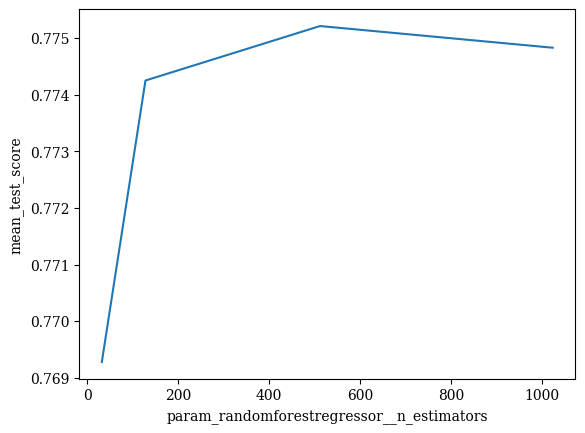

In [57]:
sns.lineplot(x="param_randomforestregressor__n_estimators", y="mean_test_score",
             #hue="param_randomforestregressor__max_features", # style="event",
             data=train_data)
plt.show()

%<br>
## Avaliação do modelo linear

In [58]:
print("Linear Regression Model")
print("Train Score: ", linReg.score(X_train, y_train))
print("Test Score: ", linReg.score(X_test, y_test))
print("Validation Score: ", r2_score(y_valid, linReg.predict(X_valid)))
print("RMSE Score: ", 100*rmse(y_train, linReg.predict(X_train)))

Linear Regression Model
Train Score:  0.6812565803389656
Test Score:  0.7307528015164673
Validation Score:  0.716973472955452
RMSE Score:  19.534793543226286


[6.19770277e-01 3.22278787e-01 6.94125143e-02 6.79430888e-05]


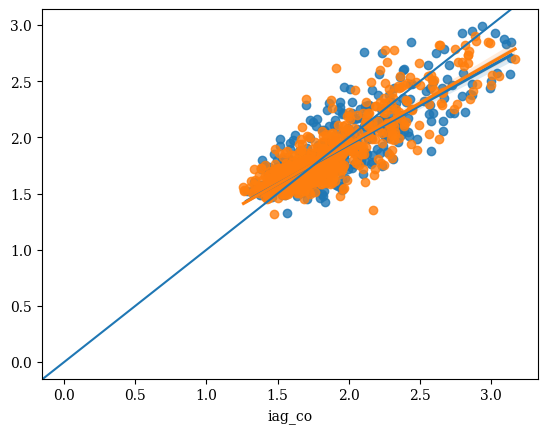

In [59]:
print(linReg.coef_)
# Visualização dos resultados do modelo linear
sns.regplot(x = y_valid, y = linReg.predict(X_valid))
sns.regplot(x = y_test, y = linReg.predict(X_test))
plt.gca().axline((0,0), slope=1)
plt.show()

%

r2_score(y_true, y_pred)<br>
x = X_train[:, 0]<br>
print("Sem regr", r2_score(x, y_train))<br>
print("w/o  ML model Score: ", r2_score(X_train['e2sp_co'], y_train))<br>
## Avaliação do modelo Random Forest

In [60]:
print("Random Forest Model")
print("Train Score: ", gs.score(X_train, y_train))
print("Test Score: ", gs.score(X_test, y_test))
print("Validation Score: ", r2_score(y_valid, gs.predict(X_valid)))
print("RMSE Score: ", 100*rmse(y_train, gs.predict(X_train)))

Random Forest Model
Train Score:  0.9701819452004536
Test Score:  0.7771308239372005
Validation Score:  0.781894582064296
RMSE Score:  5.974861823444356


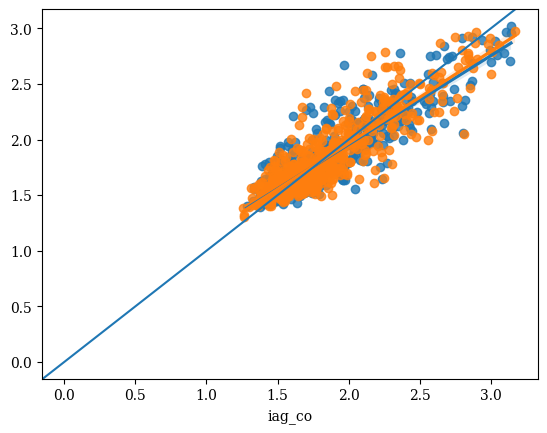

In [61]:
sns.regplot(x = y_valid, y = gs.predict(X_valid))
sns.regplot(x = y_test, y = gs.predict(X_test))
plt.gca().axline((0,0), slope=1)

In [62]:
plt.show()

% Antes de tudo<br>
## Visualização do modelo calibrado vs referência

In [63]:
e1_rf = {'co' : pd.DataFrame(data=gs.predict(Xco), index=Xco.index)}
# e1 = {'co' : df['e2sp_co']}
e2_ref = {'co' : df['iag_co']}

/home/pedro-mujica/projects/IC/aqm-dataset/estacao-grafana/envcity_plot_lib.py:49: SyntaxWarning: invalid escape sequence '\m'
  ax1.set_title(f"$\mathrm{{{latex_labels[idx]}}}$ Concentration from {start} to {end}")
/home/pedro-mujica/projects/IC/aqm-dataset/estacao-grafana/envcity_plot_lib.py:94: SyntaxWarning: invalid escape sequence '\m'
  ax.set_title(f"$\mathrm{{{latex_labels[idx]}}}$ Concentration from {start} to {end}")
/home/pedro-mujica/projects/IC/aqm-dataset/estacao-grafana/envcity_plot_lib.py:136: SyntaxWarning: invalid escape sequence '\m'
  ax.set_title(f"$\mathrm{{{latex_labels[idx]}}}$ Concentration from {start} to {end}", fontsize = 10)
/home/pedro-mujica/projects/IC/aqm-dataset/estacao-grafana/envcity_plot_lib.py:162: SyntaxWarning: invalid escape sequence '\m'
  ax.set_title(f"$\mathrm{{{latex_labels[idx]}}}$ Concentration from {start} to {end}", fontsize = 10)
/home/pedro-mujica/projects/IC/aqm-dataset/estacao-grafana/envcity_plot_lib.py:218: SyntaxWarning: invalid 

KeyError: "The following id_vars or value_vars are not present in the DataFrame: ['@index']"

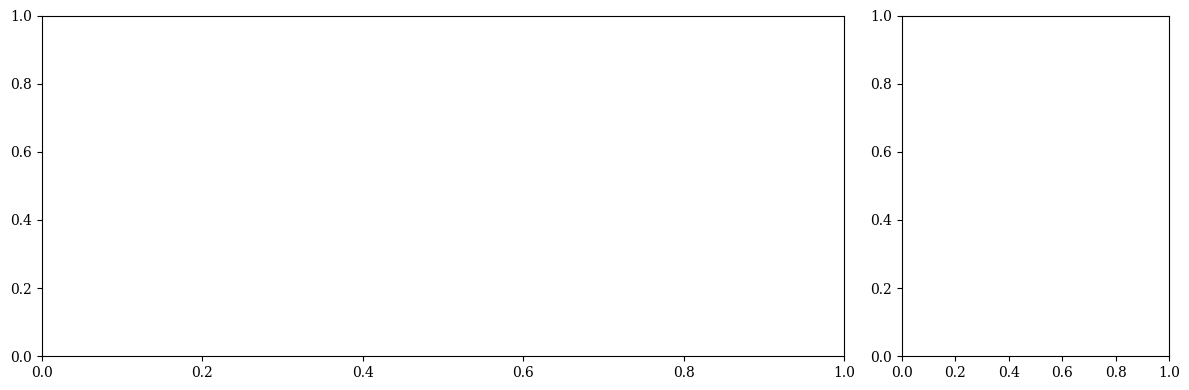

In [64]:
plot_data_by_time_and_regr_plot(e1_rf, e2_ref, labels = ['co'], latex_labels = 'co')

%<br>
 ['2023-03-18 10:00:00':'2023-03-22 10:00:00'].

In [65]:
e1_rf = {'co' : pd.DataFrame(data=linReg.predict(Xco), index=Xco.index)}
# e1 = {'co' : df['e2sp_co']}
e2_ref = {'co' : df['iag_co']}

KeyError: "The following id_vars or value_vars are not present in the DataFrame: ['@index']"

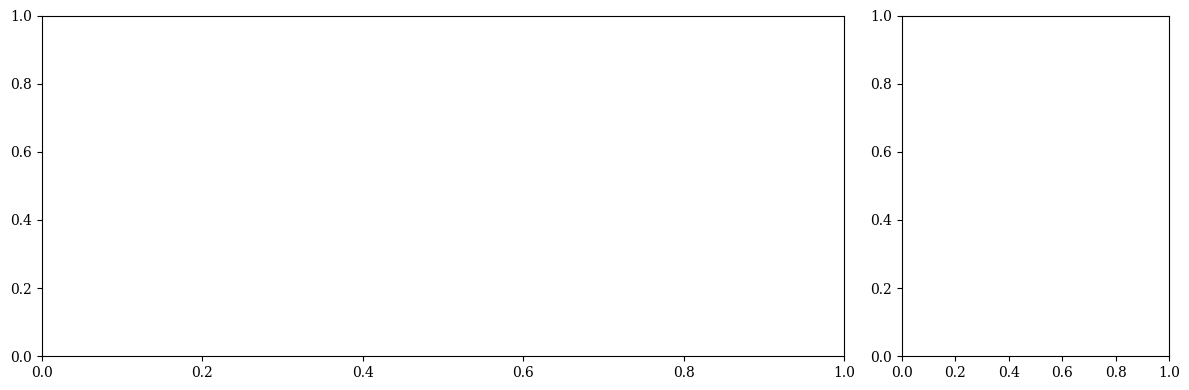

In [66]:
plot_data_by_time_and_regr_plot(e1_rf, e2_ref, labels = ['co'], latex_labels = 'co')